# Preprocessing Pipeline Documentation

## Overview

- Source: Kaggle FireSmoke Detection YOLO v9 Dataset
- Structure:
    - train/images/, train/labels/
    - valid/images/, valid/labels/
    - test/images/, test/labels/
- Each image has a corresponding YOLO .txt label file.


## Preprocessing Steps

1. Resize:
- All images resized to 640x640 pixels using Albumentations.
2. Normalization:
- Applied ImageNet standard normalization with mean = (0.485, 0.456, 0.406) and std = (0.229, 0.224, 0.225).
3. Data Augmentation:
- Horizontal Flip (50% probability)
- Random Brightness and Contrast adjustment
- Color Jittering
- Random 90-degree rotation
4. Bounding Box Handling:
- YOLO bounding boxes remain correctly aligned after transformations.
5. Splits:
- Dataset already pre-divided into train, valid, and test sets.

In [2]:
!pip install -U ipywidgets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [ipywidgets]


In [3]:
import os
from pathlib import Path
import kagglehub
import shutil


In [4]:
# Get the dataset from kaggle link
data_path = Path("../")  # more descriptive than ".."
data_path.mkdir(parents=True, exist_ok=True)

# Download dataset using kagglehub
download_path = Path(kagglehub.dataset_download("roscoekerby/firesmoke-detection-yolo-v9"))

# Move all contents from download_path to your custom data_path
for item in download_path.iterdir():
    target = data_path / item.name
    if item.is_dir():
        shutil.copytree(item, target, dirs_exist_ok=True)
    else:
        shutil.copy2(item, target)

print("Dataset moved to:", data_path.resolve())


100%|██████████| 924M/924M [00:43<00:00, 22.4MB/s] 

Extracting files...


Dataset moved to: /Users/Lee/Desktop/Project/ObjectDetection/Fire-Detection


In [14]:
# Load dataset
dataset_path = "../Fire and Smoke Dataset"
train_path = os.path.join(dataset_path, "train")
valid_path = os.path.join(dataset_path, "valid")
test_path = os.path.join(dataset_path, "test")

splits = ['train', 'valid', 'test']

In [17]:
import cv2
import matplotlib.pyplot as plt
#define a function to plot images with bounding boxes
#define a function to plot images with bounding boxes
def plot_image_with_bboxes(img_path, label_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape
    
    with open(label_path, 'r') as file:
        labels = file.readlines()
    
    for label in labels:
        class_id, x_center, y_center, bbox_width, bbox_height = map(float, label.split())
        x_center *= w
        y_center *= h
        bbox_width *= w
        bbox_height *= h
        
        x1 = int(x_center - bbox_width / 2)
        y1 = int(y_center - bbox_height / 2)
        x2 = int(x_center + bbox_width / 2)
        y2 = int(y_center + bbox_height / 2)
        
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

Showing samples from TRAIN set:


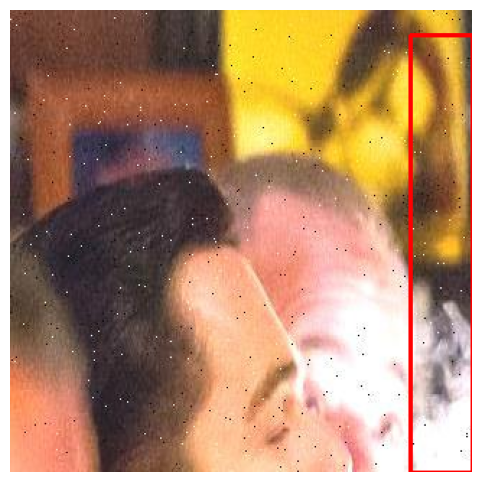

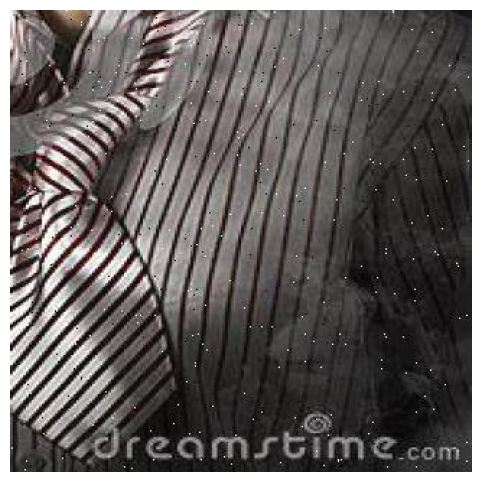

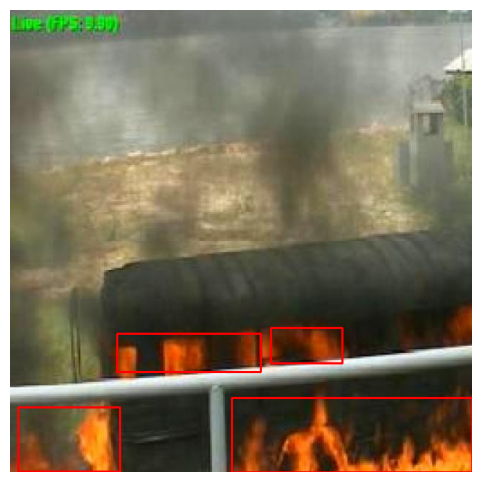

Showing samples from VALID set:


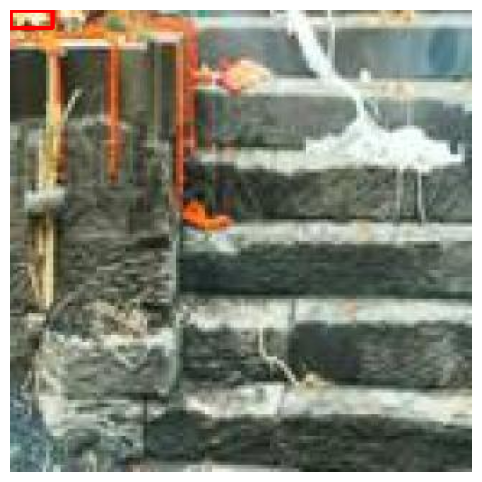

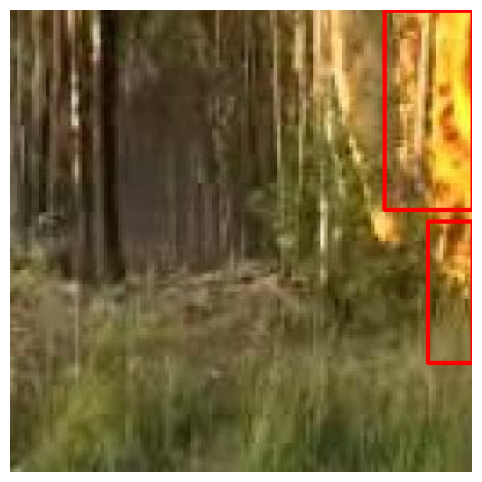

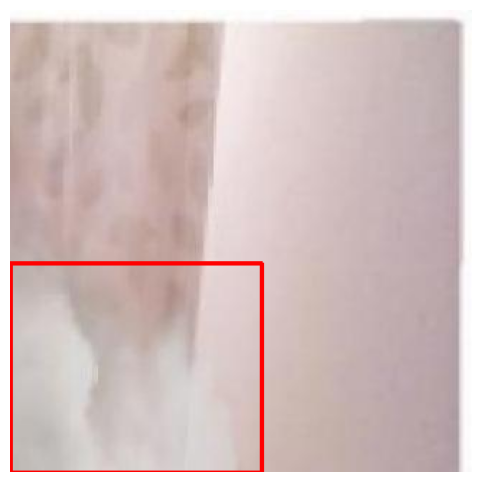

Showing samples from TEST set:


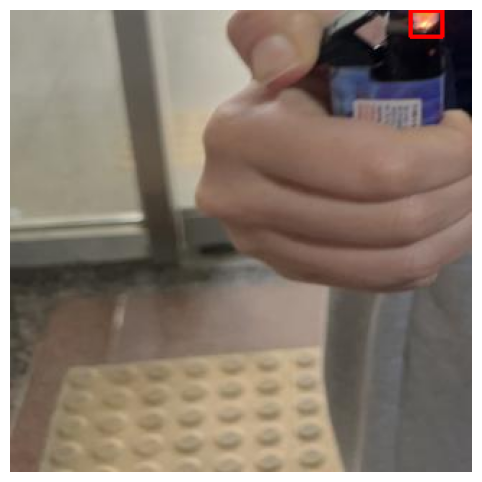

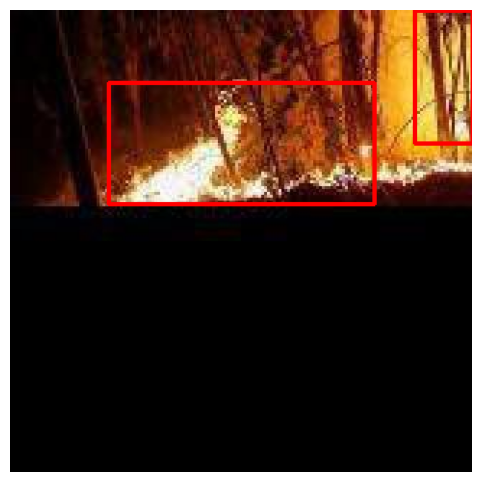

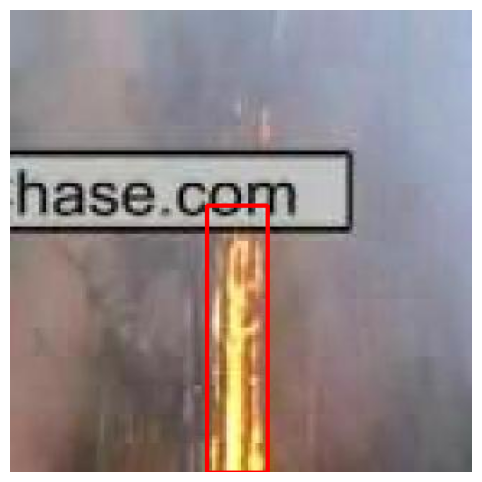

In [18]:
import random
for split in splits:
    print(f"Showing samples from {split.upper()} set:")
    images_folder = os.path.join(dataset_path, split, 'images')
    labels_folder = os.path.join(dataset_path, split, 'labels')
    
    sample_images = random.sample(os.listdir(images_folder), 3)

    for img_name in sample_images:
        img_path = os.path.join(images_folder, img_name)
        label_path = os.path.join(labels_folder, img_name.replace('.jpg', '.txt'))
        plot_image_with_bboxes(img_path, label_path)

# EDA

## Classes Distribution 

In [32]:
from collections import Counter
def count_classes(labels_dir):
    counter = Counter()
    for label_file in os.listdir(labels_dir):
        # Skip if the file is not .txt
        if not label_file.endswith('.txt'):
            continue
        
        # Open the file to extract number of classes
        file_path = os.path.join(labels_dir, label_file)
        try:
            with open(file_path, 'r') as f:
                for line in f:
                    line = line.strip()
                    
                    if not line:  # Skip empty lines
                        continue
                    parts = line.split()
                    if len(parts) >= 1: # object has been detected
                        class_id = int(parts[0])
                        counter[class_id] += 1
        except Exception as e:
            print(f"Error processing {file_path}: {str(e)}")
            continue

    return counter

# Get class counts
label_dirs = os.path.join(dataset_path,'train','labels')
train_class_counts = count_classes(label_dirs)

# Mapping classes with its label 0->Fire, 1->Smoke
class_map = {0: 'Fire', 1: 'Smoke'}

classes = [class_map.get(id) for id in train_class_counts.keys()]
counts = list(train_class_counts.values())

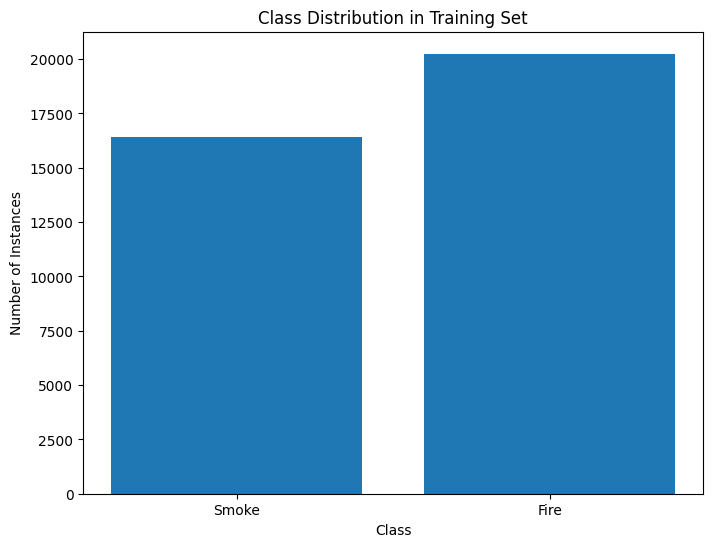

In [37]:
plt.figure(figsize=(8,6))
plt.bar(classes, counts)
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.title('Class Distribution in Training Set')
plt.show()